## Transfer learning - CNN

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

(train, test), info = tfds.load(
    "tf_flowers", split=["train[:80%]", "train[20%:]"], as_supervised=True, with_info=True)

info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='C:\\Users\\fredr\\tensorflow_datasets\\tf_flowers\\3.0.1',
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [29]:
label_names = ["dandelion/",
"daisy/",
"tulips/",
"sunflowers/",
"roses/",]

In [30]:
train 

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

img_sample[0].shape=TensorShape([333, 500, 3]), label: img_sample[1].shape=TensorShape([])
img_sample[0].shape=TensorShape([212, 320, 3]), label: img_sample[1].shape=TensorShape([])
img_sample[0].shape=TensorShape([240, 320, 3]), label: img_sample[1].shape=TensorShape([])
img_sample[0].shape=TensorShape([240, 320, 3]), label: img_sample[1].shape=TensorShape([])
img_sample[0].shape=TensorShape([317, 500, 3]), label: img_sample[1].shape=TensorShape([])
img_sample[0].shape=TensorShape([212, 320, 3]), label: img_sample[1].shape=TensorShape([])
img_sample[0].shape=TensorShape([240, 240, 3]), label: img_sample[1].shape=TensorShape([])
img_sample[0].shape=TensorShape([333, 500, 3]), label: img_sample[1].shape=TensorShape([])


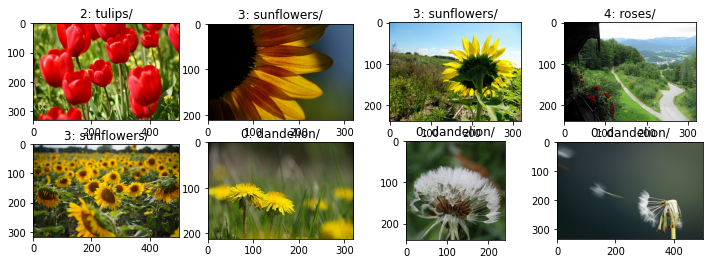

In [31]:
fig, axes = plt.subplots(2,4, figsize = (12,4))

for i, img_sample in enumerate(train.take(8)):
    print(f"{img_sample[0].shape=}, label: {img_sample[1].shape=}")
    ax = axes.flatten()[i]
    ax.imshow(img_sample[0])
    ax.set_title(f"{img_sample[1]}: {label_names[img_sample[1]]}")

## Preprocessing

In [32]:
import tensorflow as tf

def preprocessing(img, label, img_shape = (120,120)):
    img = tf.image.resize(img, img_shape)/255.0
    return img, label

input_shape = 120,120,3
batch_size = 32

train_batch = train.shuffle(buffer_size=600).map(
    preprocessing).batch(batch_size).prefetch(1)

test_batch = test.map(preprocessing).batch(batch_size).prefetch(1)

train_batch

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Transfer Learning

In [33]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights = "imagenet", include_top = False, input_shape = (input_shape))

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 120, 120, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 120, 120, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 60, 60, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 60, 60, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 60, 60, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 30, 30, 128)       0     

In [36]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Flatten, Dropout

model = Sequential([
    base_model,
    Flatten(),
    Dropout(.5),
    Dense(256, activation = "relu", kernel_initializer = "he_normal"),
    Dropout(.5),
    Dense(5, activation = "softmax")
], name = "MyModel")

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer= "adam", loss = "sparse_categorical_crossentropy")

model.summary()

Model: "MyModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 4608)              0         
                                                                 
 dropout_10 (Dropout)        (None, 4608)              0         
                                                                 
 dense_10 (Dense)            (None, 256)               1179904   
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 15,895,877
Trainable params: 1,181,189
Non-tr